# Introduction

In [2]:
import os
import sys

REPO_PATH = "/home/osero/Desktop/CMPE/dinov2/dinov2" # Specify a local path to the repository (or use installed package instead)
sys.path.append(REPO_PATH)

REPO_PATH = "/home/osero/Desktop/CMPE/dinov2" # Specify a local path to the repository (or use installed package instead)
sys.path.append(REPO_PATH)

REPO_PATH = "/home/osero/Desktop/CMPE" # Specify a local path to the repository (or use installed package instead)
sys.path.append(REPO_PATH)

from skimage.measure import find_contours
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms as pth_transforms
from PIL import Image
import numpy as np
from dinov2.models.vision_transformer import vit_small, vit_large


os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

# export XFORMERS_DISABLED=True
# printenv XFORMERS_DISABLED

/home/osero/miniconda3/envs/dinov2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/osero/Desktop/CMPE/dinov2/dinov2/layers/swiglu_ffn.py:47: UserWarning: xFormers is disabled (SwiGLU)
  warnings.warn("xFormers is disabled (SwiGLU)")
/home/osero/Desktop/CMPE/dinov2/dinov2/layers/swiglu_ffn.py:53: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/osero/Desktop/CMPE/dinov2/dinov2/layers/attention.py:31: UserWarning: xFormers is disabled (Attention)
  warnings.warn("xFormers is disabled (Attention)")
/home/osero/Desktop/CMPE/dinov2/dinov2/layers/attention.py:35: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/osero/Desktop/CMPE/dinov2/dinov2/layers/block.py:37: UserWarning: xForm

# Load modal

In [3]:
image_size = (952, 952)
output_dir = '.'
patch_size = 14

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# from dinov2.models.vision_transformer import vit_large 

model = vit_large(
    patch_size=14,
    img_size=526,
    init_values=1.0,
    block_chunks=0
 )
# model.load_state_dict(torch.load('/home/osero/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth'))
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14", force_reload=True)


for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/osero/.cache/torch/hub/main.zip


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1):

# Get image

In [13]:
# img = Image.open('dino_test_imgs/img.png')
img = Image.open('sign_language_photo/Screenshot1_head.png')
img = img.convert('RGB')
transform = pth_transforms.Compose([
    pth_transforms.Resize(image_size),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)
print(img.shape)


torch.Size([3, 952, 952])


# Arrange image

In [14]:
# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

print(img.shape)


torch.Size([1, 3, 952, 952])


# Get attentions

In [15]:

attentions = model.get_last_self_attention(img.to(device))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
# for every patch
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
# weird: one pixel gets high attention over all heads?
print(torch.max(attentions, dim=1))
#attentions[:, 283] = 0 
attentions[:, torch.argmax(attentions, dim=1).bincount().argmax()] = 0 

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)


torch.return_types.max(
values=tensor([0.1915, 0.2953, 0.6026, 0.1583, 0.1122, 0.3543, 0.1454, 0.1458, 0.3928,
        0.2153, 0.4286, 0.4989, 0.0676, 0.3137, 0.5100, 0.4430],
       device='cuda:0'),
indices=tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       device='cuda:0'))


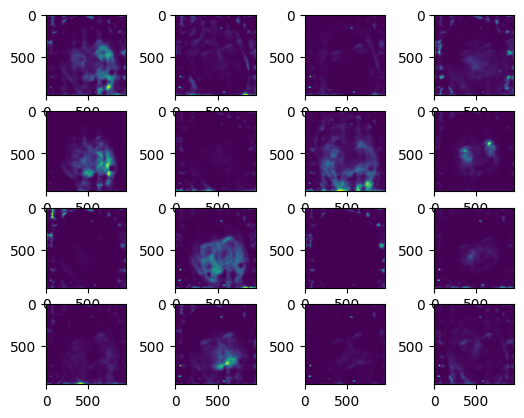

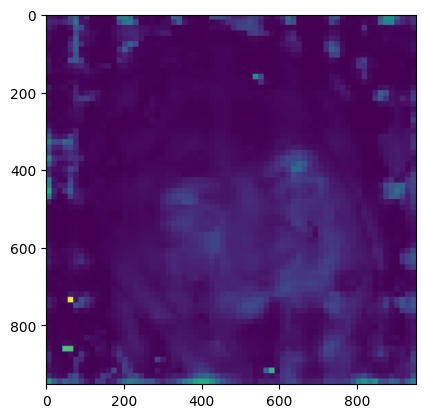

In [16]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(attentions[i])

plt.show()

plt.imshow(attentions_mean)


# Save attentions

In [17]:
# save attentions heatmaps
os.makedirs(output_dir, exist_ok=True)

fname = os.path.join(output_dir, "dino_test_imgs/attn-head/attn-head-mean.png")
plt.imsave(fname=fname, arr=attentions_mean, format='png')
print(f"{fname} saved.")

for j in range(nh):
    fname = os.path.join(output_dir, "dino_test_imgs/attn-head/attn-head" + str(j) + ".png")
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    print(f"{fname} saved.")

./dino_test_imgs/attn-head/attn-head-mean.png saved.
./dino_test_imgs/attn-head/attn-head0.png saved.
./dino_test_imgs/attn-head/attn-head1.png saved.
./dino_test_imgs/attn-head/attn-head2.png saved.
./dino_test_imgs/attn-head/attn-head3.png saved.
./dino_test_imgs/attn-head/attn-head4.png saved.
./dino_test_imgs/attn-head/attn-head5.png saved.
./dino_test_imgs/attn-head/attn-head6.png saved.
./dino_test_imgs/attn-head/attn-head7.png saved.
./dino_test_imgs/attn-head/attn-head8.png saved.
./dino_test_imgs/attn-head/attn-head9.png saved.
./dino_test_imgs/attn-head/attn-head10.png saved.
./dino_test_imgs/attn-head/attn-head11.png saved.
./dino_test_imgs/attn-head/attn-head12.png saved.
./dino_test_imgs/attn-head/attn-head13.png saved.
./dino_test_imgs/attn-head/attn-head14.png saved.
./dino_test_imgs/attn-head/attn-head15.png saved.
